In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D, MaxPooling1D



In [2]:
# Text preprocessing function

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [3]:
# Read dataset & Preprocess text


df_train = pd.read_csv('./dataset/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('./dataset/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('./dataset/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

In [4]:
# replaceKeys = {
#     'sadness': 0,
#     'anger': 1,
#     'joy': 2,
#     'fear': 3
# }

# for i in y_train:
#     i = replaceKeys[i]
# for i in y_test:
#     i = replaceKeys[i]
# for i in y_val:
#     i = replaceKeys[i]

In [5]:
# Visualize classes counts

sns.countplot(y_train)
plt.title("Training data - classes counts")
plt.show()

sns.countplot(y_test)
plt.title("Testing data - classes counts")
plt.show()

sns.countplot(y_val)
plt.title("Validation data - classes counts")
plt.show()

ValueError: could not convert string to float: 'sadness'

In [6]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [7]:

# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [8]:
# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
#batch_size = 30
#epochs = 2

In [9]:
# Embedding
max_features = vocabSize
maxlen = X_train.shape[1]
embedding_size = 200

# Convolution
kernel_size = 5
filters = 128
pool_size = 4

# LSTM
lstm_output_size = 128

# Training
#batch_size = 30
#epochs = 2

In [10]:
print('Build model...')

model = Sequential()
model.add(Embedding(vocabSize, embedding_size, input_length=X_train.shape[1]))
model.add(Dropout(0.20))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(6))
model.add(Activation('softmax'))
model.summary()

Build model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3237000   
                                                                 
 dropout (Dropout)           (None, 256, 200)          0         
                                                                 
 conv1d (Conv1D)             (None, 252, 128)          128128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                         

In [11]:
adam = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [17]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

In [18]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
63/63 [==============================] - 28s 440ms/step - loss: 0.0208 - accuracy: 0.9927 - val_loss: 0.3905 - val_accuracy: 0.8910
Epoch 2/30
63/63 [==============================] - 29s 467ms/step - loss: 0.0215 - accuracy: 0.9925 - val_loss: 0.4024 - val_accuracy: 0.9020
Epoch 3/30
63/63 [==============================] - 30s 481ms/step - loss: 0.0144 - accuracy: 0.9942 - val_loss: 0.4210 - val_accuracy: 0.8980
Epoch 4/30
63/63 [==============================] - 31s 492ms/step - loss: 0.0125 - accuracy: 0.9952 - val_loss: 0.3799 - val_accuracy: 0.8990
Epoch 5/30
63/63 [==============================] - 33s 525ms/step - loss: 0.0147 - accuracy: 0.9940 - val_loss: 0.4433 - val_accuracy: 0.8970
Epoch 6/30
63/63 [==============================] - 34s 536ms/step - loss: 0.0179 - accuracy: 0.9933 - val_loss: 0.4323 - val_accuracy: 0.8965
Epoch 7/30
63/63 [==============================] - 34s 533ms/step - loss: 0.0139 - accuracy: 0.9949 - val_loss: 0.4603 - val_accuracy: 0.8940

In [19]:
model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 1s 19ms/step - loss: 0.3957 - accuracy: 0.9020


[0.39566749334335327, 0.9020000100135803]

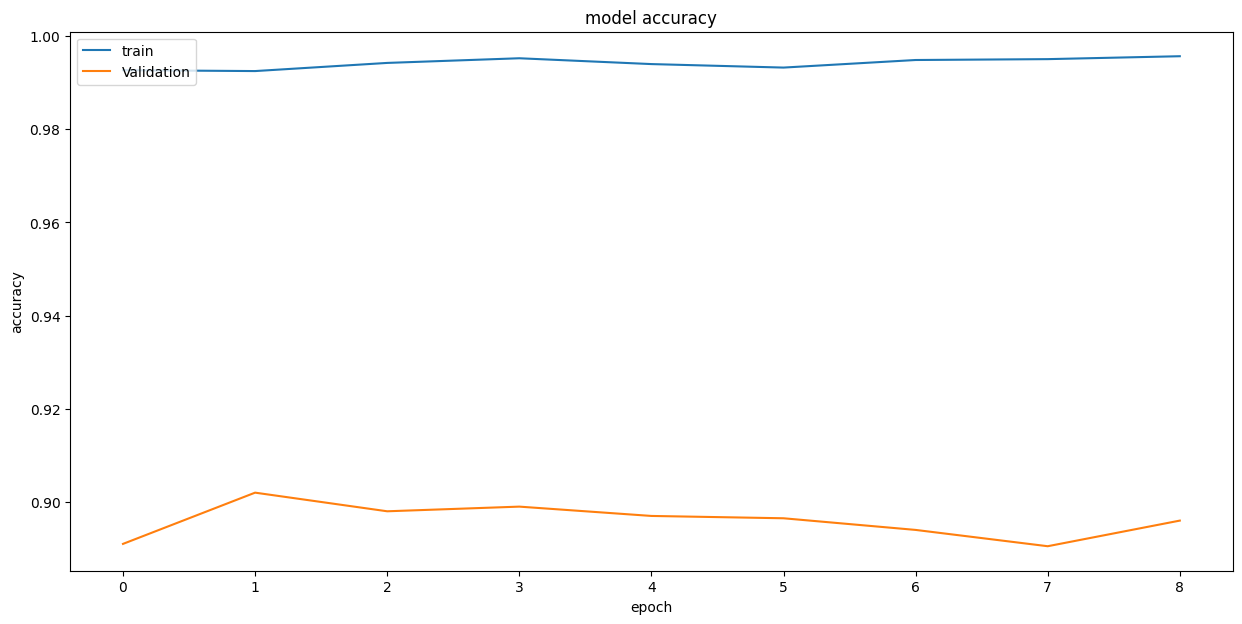

In [20]:
plt.figure(figsize=(15,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

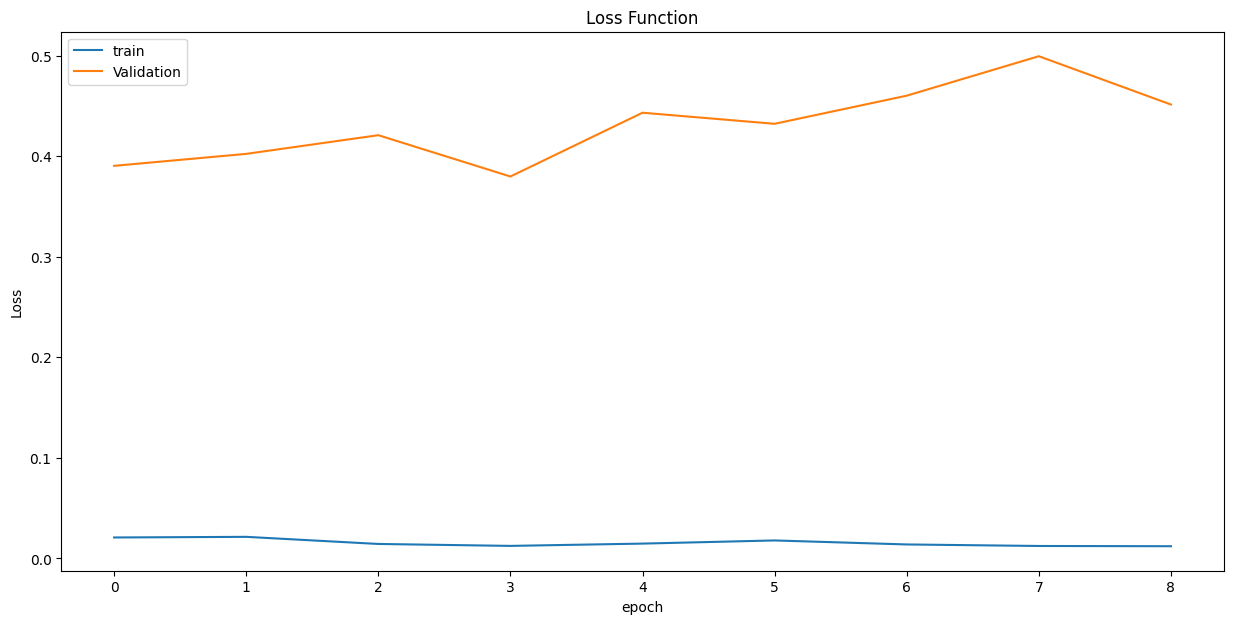

In [21]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Function')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()


In [22]:
# Classify custom sample
def predict(sentence):
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

In [23]:
predict("My grandfather was a terrorist who killed 300 Jews")

My grandfather was a terrorist who killed 300 Jews
1/1 [==============================] - 0s 16ms/step
sadness : 0.9999216794967651




In [24]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
model.save('Emotion Detection.h5')

In [52]:
# Classify custom sample
def totalPredict(sentence):
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")
    if proba < 0.48:
        return "neutral"
    return result

In [54]:
totalPredict("The transformer-based language models have been showing promising progress on a number of different natural language processing (NLP) benchmarks.")

The transformer-based language models have been showing promising progress on a number of different natural language processing (NLP) benchmarks.
1/1 [==============================] - 0s 26ms/step
joy : 0.9237310886383057




'joy'

In [55]:


with open('padProcesses.pickle', 'wb') as f:
    pickle.dump(pad_sequences, f)

In [56]:
model.save('emotionDetector')

INFO:tensorflow:Assets written to: emotionDetector\assets


INFO:tensorflow:Assets written to: emotionDetector\assets
